In [1]:
import matplotlib
import matplotlib.pyplot as plt


In [2]:
import networkx as nx
import community
import pandas as pd

import numpy as np
import json


In [3]:
from networkx.algorithms.community import greedy_modularity_communities


In [4]:
from importlib.machinery import SourceFileLoader

tools = SourceFileLoader("tools", "../tools.py").load_module()

from tools import write_to_file, test_kruskal


In [5]:
%matplotlib inline

import matplotlib.patches as mpatches
import matplotlib.lines as lines

font = {'size'   : 10,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [6]:
ipd = pd.read_csv("../data/prisoners_dilemma_articles_meta_data.csv")
anarchy = pd.read_csv("../data/price_of_anarchy_articles_meta_data.csv")
auction = pd.read_csv("../data/auction_theory_articles_meta_data.csv")

dataframes = [ipd, auction, anarchy]


In [7]:
periods = []
for data in dataframes:
    period = np.sort(data["date"].unique())
    period = period[~np.isnan(period)]
    periods.append(period[1:])


 Collaborativeness 
---------------------------

In [8]:
graphs = []
for filename in ["pd_graph.gml", "auction_graph.gml", "anarchy_graph.gml"]:
    graphs.append(nx.read_gml("../data/networks/{}".format(filename)))


Illustrating co-authors network
------------------------

**Use Gephi**

Network Metrics
-----------------------

In [9]:
number_edges = [nx.number_of_edges(G) for G in graphs]
number_nodes = [nx.number_of_nodes(G) for G in graphs]


In [10]:
for filename, metric in zip(
    ["pd_edges.txt", "pd_unique_authors.txt"], [number_edges[0], number_nodes[0]]
):
    write_to_file(filename=filename, metric=metric)


Collaborative Behaviour
-----------------------------

In [11]:
def collaborative_metrics_of_graph(graph):
    """
    Returns the following metrics:
    - number of nodes
    - number of edges
    - number of isolated authors
    - percentage of isolated authors
    - number of connected components
    - size of the largest connected component
    - average degree
    - clustering coefficients
    - modularity
    """
    num_nodes = nx.number_of_nodes(graph)
    num_edges = nx.number_of_edges(graph)
    isolated_nodes = len(list(nx.isolates(graph)))
    percentage_isolated_nodes = np.round(isolated_nodes / num_nodes, 3) * 100
    number_connected_components = nx.number_connected_components(graph)
    size_of_largest_cc = len(max(nx.connected_components(graph), key=len))

    degree_distribution = sorted([d for n, d in graph.degree()], reverse=True)
    av_degree = np.round(np.mean(degree_distribution), 3)

    clustering_coeff = round(nx.average_clustering(graph), 3)

    try:
        number_of_communities = len(list(greedy_modularity_communities(graph)))
    except ZeroDivisionError:
        number_of_communities = "-"

    communities = community.best_partition(graph)
    try:
        modularity = community.modularity(partition=communities, graph=graph)
    except ValueError:
        modularity = "-"

    metrics = {
        "# Nodes": num_nodes,
        "# Edges": num_edges,
        "# Isolated nodes": isolated_nodes,
        "% Isolated nodes": round(percentage_isolated_nodes, 3),
        "# Connected components": number_connected_components,
        "Size of largest component": size_of_largest_cc,
        "Av. degree": av_degree,
        "Clustering coeff": clustering_coeff,
        "# Communities": number_of_communities,
        "Modularity": modularity,
    }

    return metrics, degree_distribution


**Network Metrics**

In [12]:
metrics = [collaborative_metrics_of_graph(G)[0] for G in graphs]


In [13]:
metrics[0]


{'# Communities': 1369,
 '# Connected components': 1356,
 '# Edges': 10397,
 '# Isolated nodes': 176,
 '# Nodes': 5394,
 '% Isolated nodes': 3.3,
 'Av. degree': 3.855,
 'Clustering coeff': 0.708,
 'Modularity': 0.9775377686660978,
 'Size of largest component': 815}

In [14]:
degree_dstrs = [collaborative_metrics_of_graph(G)[1] for G in graphs]


In [15]:
for key in metrics[0]:
    filename = key.replace(" ", "_").replace("#", "num").replace("%", "perce") + ".txt"
    write_to_file(filename, metrics[0][key])


**Analysing clusters**

In [16]:
center_clusters = [max(nx.connected_component_subgraphs(G), key=len) for G in graphs]


In [17]:
center_clusters_metrics = [
    collaborative_metrics_of_graph(G)[0] for G in center_clusters
]


**Tables**

In [18]:
columns_order = [
    "# Nodes",
    "# Edges",
    "# Isolated nodes",
    "% Isolated nodes",
    "# Connected components",
    "Size of largest component",
    "Av. degree",
    "# Communities",
    "Modularity",
    "Clustering coeff",
]


In [19]:
metrics_table = pd.DataFrame.from_dict(metrics).round(3)
metrics_table.index = ["Prisoner's Dilemma", "Auction Games", "Price of Anarchy"]


In [20]:
metrics_table = metrics_table.reindex(columns_order, axis=1)


In [21]:
metrics_table


,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,# Communities,Modularity,Clustering coeff
Prisoner's Dilemma,5394,10397,176,3.3,1356,815,3.855,1369,0.978,0.708
Auction Games,5165,7861,256,5.0,1272,1348,3.044,1297,0.957,0.622
Price of Anarchy,1155,1953,4,0.3,245,222,3.382,253,0.964,0.712


In [22]:
write_to_file(metric=metrics_table.to_latex(), filename="network_comparison.tex")


In [23]:
clusters_table = pd.DataFrame.from_dict(center_clusters_metrics).round(3)
clusters_table.index = ["Prisoner's Dilemma", "Auction Games", "Price of Anarchy"]
clusters_table.index = ["Prisoner's Dilemma", "Auction Games", "Price of Anarchy"]
clusters_table = clusters_table.reindex(columns_order, axis=1)


In [24]:
clusters_table


,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,# Communities,Modularity,Clustering coeff
Prisoner's Dilemma,815,2300,0,0.0,1,815,5.644,28,0.856,0.775
Auction Games,1348,3158,0,0.0,1,1348,4.685,29,0.859,0.699
Price of Anarchy,222,521,0,0.0,1,222,4.694,12,0.824,0.711


In [25]:
write_to_file(metric=clusters_table.to_latex(), filename="clusters_comparison.tex")


**Degree Distribution**

In [26]:
max(degree_dstrs[0])


58

In [27]:
colors = ["darkorange", "darkred", "darkgreen"]


In [28]:
labels = [r"$G_1$", r"$G_2$", r"$G_3$"]


3.0
----
2.0
----
3.0
----


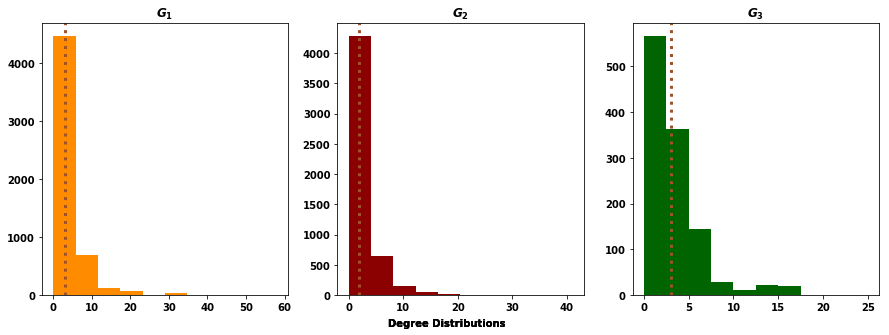

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, dstr in enumerate(degree_dstrs):
    axes[i].hist(dstr, color=colors[i])
    median = np.median(dstr)
    print(median)
    print("----")
    axes[i].axvline(median, color="sienna", linestyle=":", linewidth=3, label="median")
    axes[i].title.set_text(labels[i])

    fig.text(0.5, 0.04, "Degree Distributions", ha="center", fontsize=10)

plt.savefig("../../assets/images/networks_ditributions.pdf")


In [30]:
for dist in degree_dstrs:
    temp = pd.DataFrame(dist)
    print(temp.describe())


                 0
count  5394.000000
mean      3.855024
std       4.256835
min       0.000000
25%       2.000000
50%       3.000000
75%       5.000000
max      58.000000
                 0
count  5165.000000
mean      3.043950
std       3.010729
min       0.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      41.000000
                 0
count  1155.000000
mean      3.381818
std       2.903207
min       0.000000
25%       2.000000
50%       3.000000
75%       4.000000
max      25.000000


In [31]:
test_kruskal(degree_dstrs)


8.099763504767073e-28 The null hypothesis can be rejected.


8.099763504767073e-28

In [32]:
test_kruskal([degree_dstrs[0], degree_dstrs[1]])


7.041736535898481e-28 The null hypothesis can be rejected.


7.041736535898481e-28

In [33]:
test_kruskal([degree_dstrs[0], degree_dstrs[2]])


0.08961070548111885 The null hypothesis cannot be rejected.


0.08961070548111885

Cumulative Graphs
---------

In [34]:
linestyle = [":o", "-.", "--"]


In [35]:
import glob


In [36]:
number_of_files = [
    len(list(glob.glob("../data/networks/G_pd_*.gml"))),
    len(list(glob.glob("../data/networks/G_auction_*.gml"))),
    len(list(glob.glob("../data/networks/G_anarchy_*.gml"))),
]


In [37]:
cumulative_graphs = []
for num, file in zip(number_of_files, ["G_pd", "G_auction", "G_anarchy"]):
    sub_graphs = []
    for i in range(num):
        sub_graphs.append(nx.read_gml("../data/networks/{}_{}.gml".format(file, i)))
    cumulative_graphs.append(sub_graphs)


In [38]:
cumulative_clusters = [
    [max(nx.connected_component_subgraphs(G), key=len) for G in sub_graphs]
    for sub_graphs in cumulative_graphs
]


In [39]:
len(cumulative_graphs[0]), len(cumulative_clusters[0])


(63, 63)

In [40]:
cumulative_metrics = [
    [collaborative_metrics_of_graph(G)[0] for G in sub_graphs]
    for sub_graphs in cumulative_graphs
]


In [41]:
cumulative_cluster_metrics = [
    [collaborative_metrics_of_graph(G)[0] for G in sub_graphs]
    for sub_graphs in cumulative_clusters
]


In [42]:
total_nodes = [int(metric["# Nodes"]) for metric in metrics]
total_con = [int(metric["# Connected components"]) for metric in metrics]
largest_cc = [int(metric["Size of largest component"]) for metric in metrics]
for i in range(3):
    for sub_graph in cumulative_metrics[i]:
        sub_graph["% Nodes"] = round(sub_graph["# Nodes"] / total_nodes[i], 3)
        sub_graph["% Connected components"] = round(
            sub_graph["# Connected components"] / total_con[i], 3
        )
        sub_graph["% Size of largest"] = round(
            sub_graph["Size of largest component"] / largest_cc[i], 3
        )


**Tables**

In [43]:
with open("../../assets/periods_dictionary.json") as json_file:
    periods_dictionary = json.load(json_file)

In [44]:
cumulative_table = pd.DataFrame.from_dict(cumulative_metrics[0]).round(3)
cumulative_table.index = [
    periods_dictionary["Period {}".format(i)]
    for i, _ in enumerate(cumulative_table.index)
]
cumulative_table = cumulative_table.reindex(columns_order, axis=1)


In [45]:
cumulative_table.head(15)


,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,# Communities,Modularity,Clustering coeff
1954 - 1950,3,0,3,100.0,3,1,0.000,-,-,0.000
1954 - 1955,2,0,2,100.0,2,1,0.000,-,-,0.000
1955 - 1956,3,0,3,100.0,3,1,0.000,-,-,0.000
1956 - 1957,4,0,4,100.0,4,1,0.000,-,-,0.000
1957 - 1958,6,0,6,100.0,6,1,0.000,-,-,0.000
1958 - 1959,7,0,7,100.0,7,1,0.000,-,-,0.000
1959 - 1961,7,0,7,100.0,7,1,0.000,-,-,0.000
1961 - 1962,8,0,8,100.0,8,1,0.000,-,-,0.000
1962 - 1964,9,0,9,100.0,9,1,0.000,-,-,0.000
1964 - 1965,10,0,10,100.0,10,1,0.000,-,-,0.000


In [46]:
write_to_file(
    metric=cumulative_table.to_latex(), filename="cumulative_graphs_table.tex"
)


In [47]:
clusters_cum_table = pd.DataFrame.from_dict(cumulative_cluster_metrics[0]).round(3)
clusters_cum_table.index = [
    periods_dictionary["Period {}".format(i)]
    for i, _ in enumerate(clusters_cum_table.index)
]
clusters_cum_table = clusters_cum_table.reindex(columns_order, axis=1)


In [48]:
write_to_file(
    metric=clusters_cum_table.to_latex(), filename="cumulative_clusters_table.tex"
)


**Metric Plots**

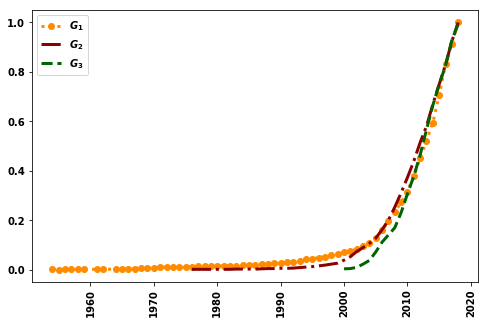

In [49]:
fig = plt.figure(figsize=(8, 5))
for i in range(3):
    y = [entry["% Nodes"] for entry in cumulative_metrics[i]]
    plt.plot(periods[i], y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])
plt.xticks(rotation=90)
plt.legend()

plt.savefig("../../assets/images/percentage_networks_nodes.pdf")


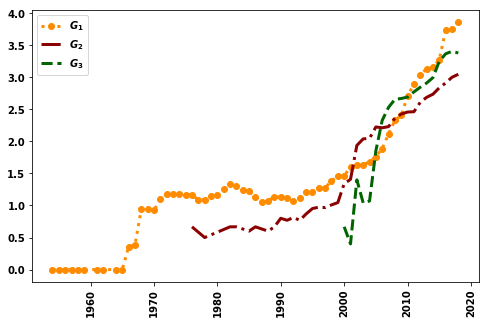

In [50]:
fig = plt.figure(figsize=(8, 5))
for i in range(3):
    y = [entry["Av. degree"] for entry in cumulative_metrics[i]]
    plt.plot(periods[i], y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])

plt.xticks(rotation=90)
plt.legend()
plt.savefig("../../assets/images/degrees_over_time.pdf")


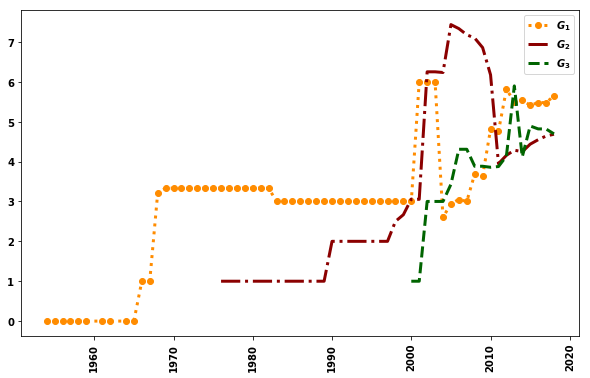

In [51]:
fig = plt.figure(figsize=(10, 6))
for i in range(3):
    y = [entry["Av. degree"] for entry in cumulative_cluster_metrics[i]]
    plt.plot(periods[i], y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])
plt.xticks(rotation=90)
plt.legend()

plt.savefig("../../assets/images/degrees_over_time_cluster.pdf")


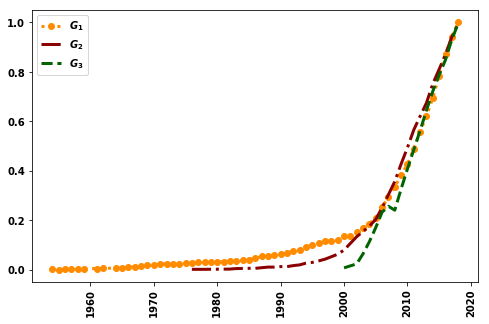

In [52]:
fig = plt.figure(figsize=(8, 5))
for i in range(3):
    y = [entry["% Connected components"] for entry in cumulative_metrics[i]]
    plt.plot(periods[i], y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])

plt.xticks(rotation=90)
plt.legend()

plt.savefig("../../assets/images/connected_components_over_time.pdf")


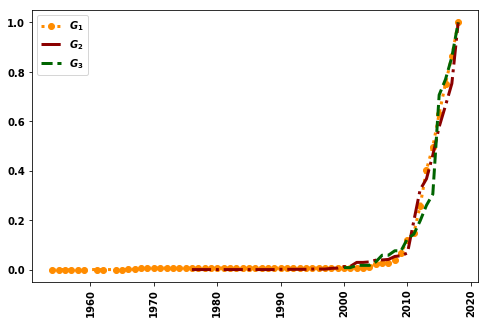

In [53]:
fig = plt.figure(figsize=(8, 5))
for i in range(3):
    y = [entry["% Size of largest"] for entry in cumulative_metrics[i]]
    plt.plot(periods[i], y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])

plt.xticks(rotation=90)
plt.legend()

plt.savefig("../../assets/images/size_of_largest_cc_over_time.pdf")


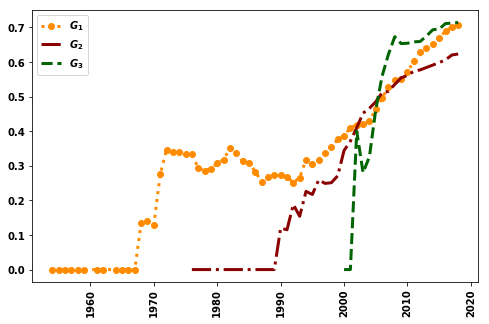

In [54]:
fig = plt.figure(figsize=(8, 5))
for i in range(3):
    y = [entry["Clustering coeff"] for entry in cumulative_metrics[i]]
    plt.plot(periods[i], y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])

plt.xticks(rotation=90)
plt.legend()

plt.savefig("../../assets/images/clustering_coeff_over_time.pdf")


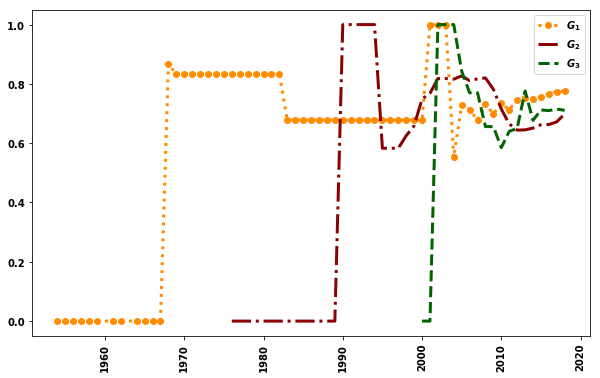

In [55]:
fig = plt.figure(figsize=(10, 6))
for i in range(3):
    y = [entry["Clustering coeff"] for entry in cumulative_cluster_metrics[i]]
    plt.plot(periods[i], y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])
plt.xticks(rotation=90)
plt.legend()

plt.savefig("../../assets/images/clustering_coeff_over_time_clusters.pdf")


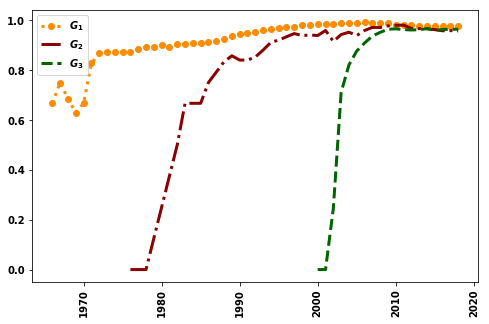

In [56]:
fig = plt.figure(figsize=(8, 5))
for i in range(3):
    y = [
        entry["Modularity"]
        for entry in cumulative_metrics[i]
        if type(entry["Modularity"]) is not str
    ]
    x = [
        period
        for j, period in enumerate(periods[i])
        if type(cumulative_metrics[i][j]["Modularity"]) is not str
    ]
    plt.plot(x, y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])
plt.xticks(rotation=90)
plt.legend()
plt.savefig("../../assets/images/modularity_over_time.pdf")


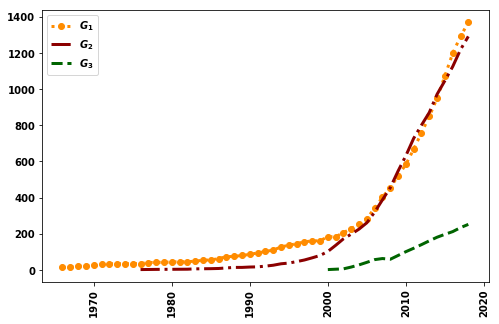

In [57]:
fig = plt.figure(figsize=(8, 5))
for i in range(3):
    y = [
        entry["# Communities"]
        for entry in cumulative_metrics[i]
        if type(entry["# Communities"]) is not str
    ]
    x = [
        period
        for j, period in enumerate(periods[i])
        if type(cumulative_metrics[i][j]["# Communities"]) is not str
    ]
    plt.plot(x, y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])

plt.xticks(rotation=90)
plt.legend()


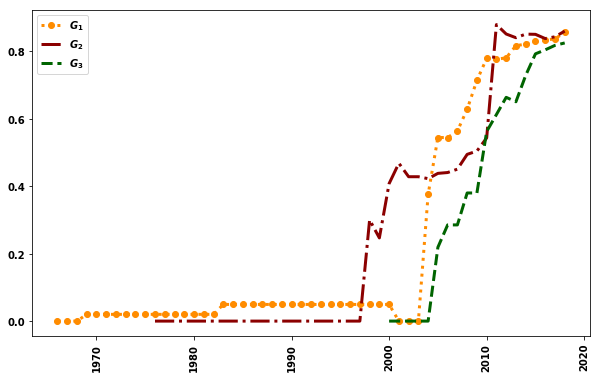

In [58]:
fig = plt.figure(figsize=(10, 6))
for i in range(3):
    y = [
        entry["Modularity"]
        for entry in cumulative_cluster_metrics[i]
        if type(entry["Modularity"]) is not str
    ]
    x = [
        period
        for j, period in enumerate(periods[i])
        if type(cumulative_cluster_metrics[i][j]["Modularity"]) is not str
    ]
    plt.plot(x, y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])
plt.xticks(rotation=90)
plt.legend()

plt.savefig("../../assets/images/modularity_over_time_cluster.pdf")


In [59]:
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
# for j, mtrcs in enumerate(['% Nodes', 'Av. degree', '# Connected components',
#                            'Size of largest component', 'Clustering coeff', 'Modularity']):

#     if mtrcs is 'Modularity':
#         for i in range(3):
#             y = [entry['Modularity'] for entry in cumulative_metrics[i] if type(entry['Modularity']) is not str]
#             x = [period for j, period in enumerate(periods[i]) if type(cumulative_metrics[i][j]['Modularity']) is not str]
#             axes[j % 3][j % 2].plot(x, y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])
#     else:
#         for i in range(3):
#             y = [entry[mtrcs] for entry in cumulative_metrics[i]]
#             axes[j % 3][j % 2].plot(periods[i], y, linestyle[i], linewidth=3, color=colors[i], label=labels[i])
#     axes[j % 3][j % 2].legend();
#     axes[j % 3][j % 2].set_title(mtrcs, fontweight="bold")
# fig.tight_layout()

# plt.savefig('../../assets/images/cum_coll_metrics.pdf')
